# Homework 7: Recurrent neuronal networks


## Imports 


In [ ]:
import tensorflow as tf
import numpy as np

sample_size = 80000
seq_len = 5

## Generator Function
Yields a random noise signal of specified size and a target.

In [ ]:
def integration_task(seq_length=5, num_samples=10000,):
    """
    Yields a num_samples times a random noise signal of size seq_length and a target.
    ## Params
        - seq_length = size of random noise signal
        - num_samples = number of random noise samples
    """
    for i in range(num_samples):
        ar = np.random.normal(size=(seq_length))
        yield (np.expand_dims(ar,-1),np.expand_dims(int(ar.sum()>0),-1))

## Wrapper Generator 
Internally iterates through integration_task.

In [ ]:
def my_integration_task():
    """Internally iterates through integration_task function"""
    for i in integration_task(5, sample_size):
        yield i

## Preprocessing pipeline


In [ ]:
# Creating Tensorflow Dataset
data = tf.data.Dataset.from_generator(my_integration_task,(tf.float32,tf.int64),(tf.TensorShape([5,1]), tf.TensorShape([1])))

def pipeline(ds,ratio):
    """Preprocessing pipeline for Tensorflow data"""
    # Splitting in train and test
    train = ds.take(int(ratio*sample_size))
    test = ds.skip(int(ratio*sample_size))
    # Shuffle
    train = train.shuffle(1000)
    test = test.shuffle(1000)
    # batch
    train = train.batch(8)
    test = test.batch(8)
    #prefetch
    train = train.prefetch(20)
    test = test.prefetch(20)

    # return preprocessed data
    return train,test

train_ds, test_ds = pipeline(data,.8) 
for a,b in train_ds.take(1):
    print(a.shape,a.dtype,b.shape,b.dtype)

(8, 5, 1) <dtype: 'float32'> (8, 1) <dtype: 'int64'>


## LSTM Cell

In [ ]:
class LSTM_Cell(tf.keras.layers.Layer):
    
    def __init__(self, units, kernel_regularizer=None ):
        super(LSTM_Cell, self).__init__()
        
        self.units = units
        
        self.forget_layer = tf.keras.layers.Dense(units, 
                                                  kernel_regularizer=kernel_regularizer, 
                                                   activation="sigmoid",
                                                  bias_initializer='ones')
        self.input_layer = tf.keras.layers.Dense(units, 
                                                  kernel_regularizer=kernel_regularizer, 
                                                 activation="sigmoid")

        self.candidates_layer = tf.keras.layers.Dense(units, 
                                                 kernel_regularizer=kernel_regularizer, 
                                                 activation="tanh")
        
        self.output_layer = tf.keras.layers.Dense(units, 
                                                 kernel_regularizer=kernel_regularizer, 
                                                 activation="sigmoid")

    def call(self, input_t,hidden_state, cell_state):

        con_input = np.concatenate([input_t,hidden_state],axis=1)

        forget_mask = self.forget_layer(con_input)

        cell_after_forget = tf.math.multiply(forget_mask,hidden_state)
        
        input_mask = self.input_layer(con_input)
        candidates = self.candidates_layer(con_input)
        new_cell_state = tf.math.add(cell_after_forget,tf.math.multiply(input_mask,candidates))
        output_mask = self.output_layer(con_input)
        
        new_hidden_state = np.multiply(output_mask,tf.nn.tanh(new_cell_state))
        
        return new_hidden_state, new_cell_state

## LSTM Wrapper


In [ ]:
class LSTMWrapper(tf.keras.layers.Layer):
    
    def __init__(self, LSTM_Cell):
        super(LSTMWrapper, self).__init__()
        
        self.cell = LSTM_Cell

    def call(self, data, hs, cs):
        out = []
        hidden_state = hs
        cell_state = cs
        for t in range(seq_len):
            hidden_state, cell_state = self.cell(data[:,t,:], hidden_state,cell_state)
            out.append(hidden_state)
        
        return out

    def zeros(self, batch_size):
        return tf.zeros((batch_size, self.cell.units), dtype=tf.float32)

## Model

In [ ]:
class RNN_Model(tf.keras.Model):

    def __init__(self):
        super(RNN_Model, self).__init__()
        self.input_ly = tf.keras.layers.Dense(units=seq_len, activation='sigmoid')
        self.LSTM =  LSTMWrapper(LSTM_Cell(2))
        self.output_ly = tf.keras.layers.Dense(units=1, activation='sigmoid')

    def call(self,data):
        x = self.input_ly(data)
        x= self.LSTM(x,self.LSTM.zeros(8),self.LSTM.zeros(8))
        return [self.output_ly(val) for val in x]

## Train and Test function
The training and test function are the same as last week. 

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    """
    Function for model training
    ## Params
        - model = instance of MyModel class
        - input = input for model 
        - target = targets
        - loss_function = loss function
        - optimizer = tensorflow optimizer
    """
    with tf.GradientTape() as tape:
        prediction = model(input)[-1]
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables, 
                unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    """
    Function for model testing 
    ## Params
        - model = instance of MyModel class
        - test_data = data for testing
        - loss_function = loss function
    """
    # we use numpy array here to speed things up
    test_accuracy_aggregator = np.empty(0)
    test_loss_aggregator = np.empty(0)

    for (input, target) in test_data:
        prediction = model(input)[-1]
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = target == np.round(prediction,0) # accuracy computation for binary task
        test_loss_aggregator = np.append(test_loss_aggregator, sample_test_loss.numpy())
        test_accuracy_aggregator = np.append(test_accuracy_aggregator, np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Running our Code

In [ ]:
tf.keras.backend.clear_session()

# define hyperparams
learning_rate = tf.constant(0.001, dtype=tf.float64) # A smaller learning rate prooved to be more useful
num_epochs = 5
model = RNN_Model()
loss_func = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate)        # Adam yielded the most stable accuracies from all tested optimizers

# arrays for later visualization
# initial tests before training
train_losses = np.empty(0)

test_loss, test_acc = test(model, test_ds, loss_func)
test_losses = np.array([test_loss])
test_accuracies = np.array([test_acc])

# model performance before training
train_loss, _ = test(model, train_ds, loss_func)
train_losses = np.append(train_losses, train_loss)

# training of our model
for epoch in range(num_epochs):
    print(f'Epoch {str(epoch)} starting with accuracy {test_accuracies[-1]:.8f}')

    epoch_loss_agg = np.empty(0)
    for input, target in train_ds:
        train_loss = train_step(model, input, target, loss_func, optimizer)
        epoch_loss_agg = np.append(epoch_loss_agg, train_loss)

    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))

    test_loss, test_acc = test(model, test_ds, loss_func)
    test_losses = np.append(test_losses, test_loss)
    test_accuracies = np.append(test_accuracies, test_acc)

Epoch 0 starting with accuracy 0.40325000
Epoch 1 starting with accuracy 0.64625000
Epoch 2 starting with accuracy 0.64443750
Epoch 3 starting with accuracy 0.64093750
Epoch 4 starting with accuracy 0.64581250


## Visualization

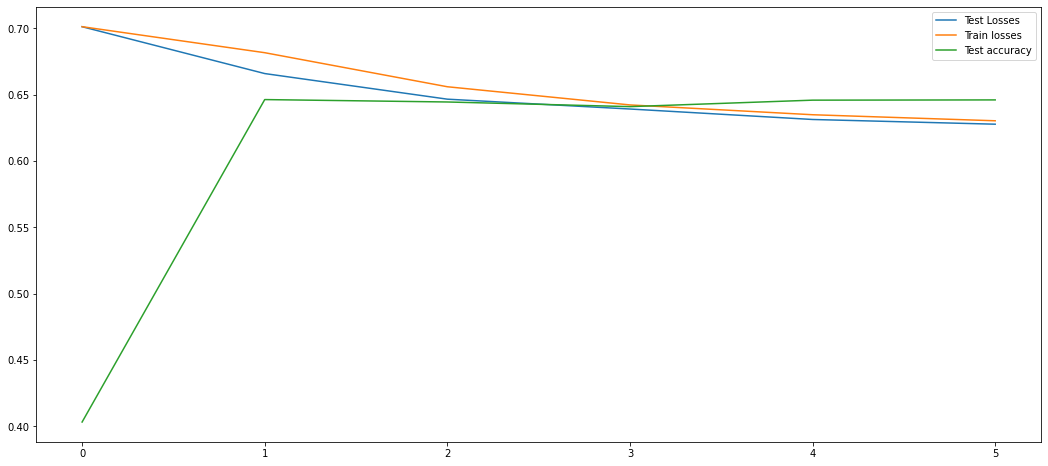

In [ ]:
import matplotlib.pyplot  as plt

#Graph
plt.figure(figsize=(18,8))
plt.plot(range(num_epochs+1),test_losses,label="Test Losses")
plt.plot(range(num_epochs+1),train_losses, label="Train losses")
plt.plot(range(num_epochs+1),test_accuracies, label = "Test accuracy")
plt.legend()
plt.show()

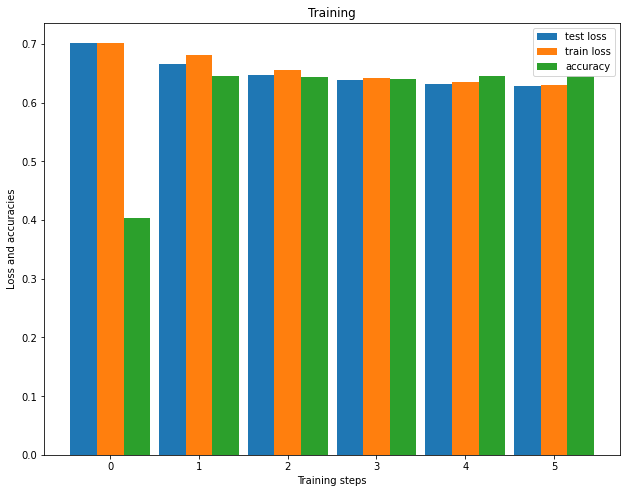

In [ ]:
# Barplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
epochs = np.arange(6)
label1 = ax.bar(epochs-0.3, test_losses, 0.3)
label2 = ax.bar(epochs, train_losses, 0.3)
label3 = ax.bar(epochs+0.3, test_accuracies, 0.3)
plt.legend([label1, label2, label3], ["test loss", "train loss", "accuracy"])
ax.set_title('Training')
ax.set_ylabel('Loss and accuracies')
ax.set_xlabel('Training steps')
ax.set_xticks(np.arange(6))
plt.show()